In [1]:
from collections import defaultdict

import pandas as pd
import numpy as np
import mne
import matplotlib.pyplot as plt

# from importlib import reload
# import feature_extraction
# reload(feature_extraction)
from biomarkers import (
    EEG,
    EMG,
    BP,
    EOG,
    ECG,
    TREV,
    GSR,
    Resp,
    EGG,
)
from feature_extraction import (
    Feature,
    EEG_BANDS,
    STAT_FEATURES,
)
from data_utils import (
    extract_features,
    extract_labels,
    load_data_from_dir,
    get_all_behaviors_labels,
    get_all_features_by_marker,
    extract_features_by_channel,
    concatenate_all_data,
)
from calculate_correlation import (
    EEG_BANDS_LIST,
    get_all_behaviors_feature_to_pc_by_markers,
    get_all_trials_average_rp_values,
)

from labels import get_categorical_labels, print_label_count

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split


/Users/tpan/miniconda3/envs/MM/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
ALL_DIRS = [
    "../2002",
]  # "../2000_CleanData", "../2001_CleanData", "../1004_CleanData"  "../2003", "../2004", "../2005", "../2006"

dir_to_data = {}
for dir_name in ALL_DIRS:
    all_data = load_data_from_dir(dir_name)
    dir_to_data[dir_name] = all_data

Loading ../2002 data...


In [3]:
""" 
  extract labels from behavior data
"""
all_label_array = extract_labels(dir_to_data, all_dir=ALL_DIRS)
label_list = get_categorical_labels(all_label_array, valence_threshold=0.65)
groups_list = [[i] for i, j in enumerate(label_list)]
group_array = np.hstack(groups_list)

In [7]:
"""
  extract features from physiological signals
"""
feature_names = []
all_feature_array = []
for m in [Resp.__name__]: # , EEG.__name__ BP.__name__, ECG.__name__, EGG.__name__
    f_array, names = (
        extract_features(m, dir_to_data, EEG_BANDS_LIST, ALL_DIRS)
        if m == EEG.__name__
        else extract_features(m, dir_to_data, all_dir=ALL_DIRS)
    )
    print(f"extracted {m} stats or PSD features")
    all_feature_array.append(f_array)
    feature_names.extend(names)

all_feature_array = np.concatenate(all_feature_array, axis=-1)

print(all_feature_array.shape, len(feature_names), len(label_list))
df = pd.DataFrame(all_feature_array, columns=feature_names)
df

extracted Resp stats or PSD features
(130, 11) 11 130


,rate_MEAN,rate_STD,rate_PTP,rate_VAR,rate_MINIM,rate_MAXIM,rate_MEAN_SQUARE,rate_RMS,rate_ABS_DIFF,rate_SKEWNESS,rate_KURTOSIS
0,13.560164,13.471994,29.282577,181.494636,0.000000,29.282577,365.372687,19.114724,42.015638,0.097743,-1.925532
1,25.717112,2.573784,8.102190,6.624362,21.897810,30.000000,667.994228,25.845584,24.531632,0.324543,-1.138033
2,23.521465,4.353931,12.204951,18.956717,16.977929,29.182879,572.216023,23.921037,30.452124,-0.294383,-1.478145
3,25.412230,3.361340,9.380612,11.298608,20.604396,29.985007,657.080051,25.633573,39.227833,-0.212572,-1.633128
4,23.493224,4.222029,12.502781,17.825532,17.467249,29.970030,569.757094,23.869585,35.647695,0.287273,-1.316441
...,...,...,...,...,...,...,...,...,...,...,...
125,22.525721,3.833208,13.185023,14.693486,16.755096,29.940120,522.101592,22.849542,36.782410,-0.063629,-0.931401
126,25.590411,4.269853,13.704508,18.231640,16.295492,30.000000,673.100781,25.944186,44.173265,-0.392828,-1.252528
127,25.455901,3.380249,8.932584,11.426083,21.067416,30.000000,659.428989,25.679349,36.584445,0.087582,-1.657734
128,24.107756,4.776716,15.733688,22.817019,14.221379,29.955067,604.000927,24.576430,50.258515,-0.465363,-0.578204


In [27]:
""" 
    save features to csv
"""

NUM_DATA_PER_SUBJECT = 130
df = pd.DataFrame(all_feature_array, columns=feature_names)

subjects = []
for i, _ in enumerate(all_feature_array):
    subjects.append(ALL_DIRS[int(i / NUM_DATA_PER_SUBJECT)])

df["Subject"] = subjects
df["Valence"] = all_label_array['valence']
df["Arousal"] = all_label_array['arousal']
df["Attention"] = all_label_array['attention']

df.to_csv("2012_2013_subjects_eeg_ecg_emg.csv", index=False)

In [47]:
"""
    load features from csv
"""
import glob

dir_name = "extracted_features"
all_files = glob.glob(dir_name + "/*.csv")
frames = []
for fn in all_files:
    df = pd.read_csv(fn)
    if fn == "extracted_features/three_subjects_eeg_ecg_emg.csv":
        # get rid of 1004
        mask = df["Subject"].isin(["../2000_CleanData", "../2001_CleanData"])
        df = df[mask]
    frames.append(df)

result = pd.concat(frames)

all_label_array = {"valence": result['Valence'].values, "arousal": result['Arousal'].values, "attention": result['Attention'].values}
label_list = get_categorical_labels(all_label_array, valence_threshold=0.65)

all_feature_array = result.drop(["Subject", "Unnamed: 0", 'Valence', 'Arousal', 'Attention'], axis=1)
feature_names = all_feature_array.columns

print(all_feature_array.shape, len(feature_names), len(label_list))

(1690, 812) 812 1690


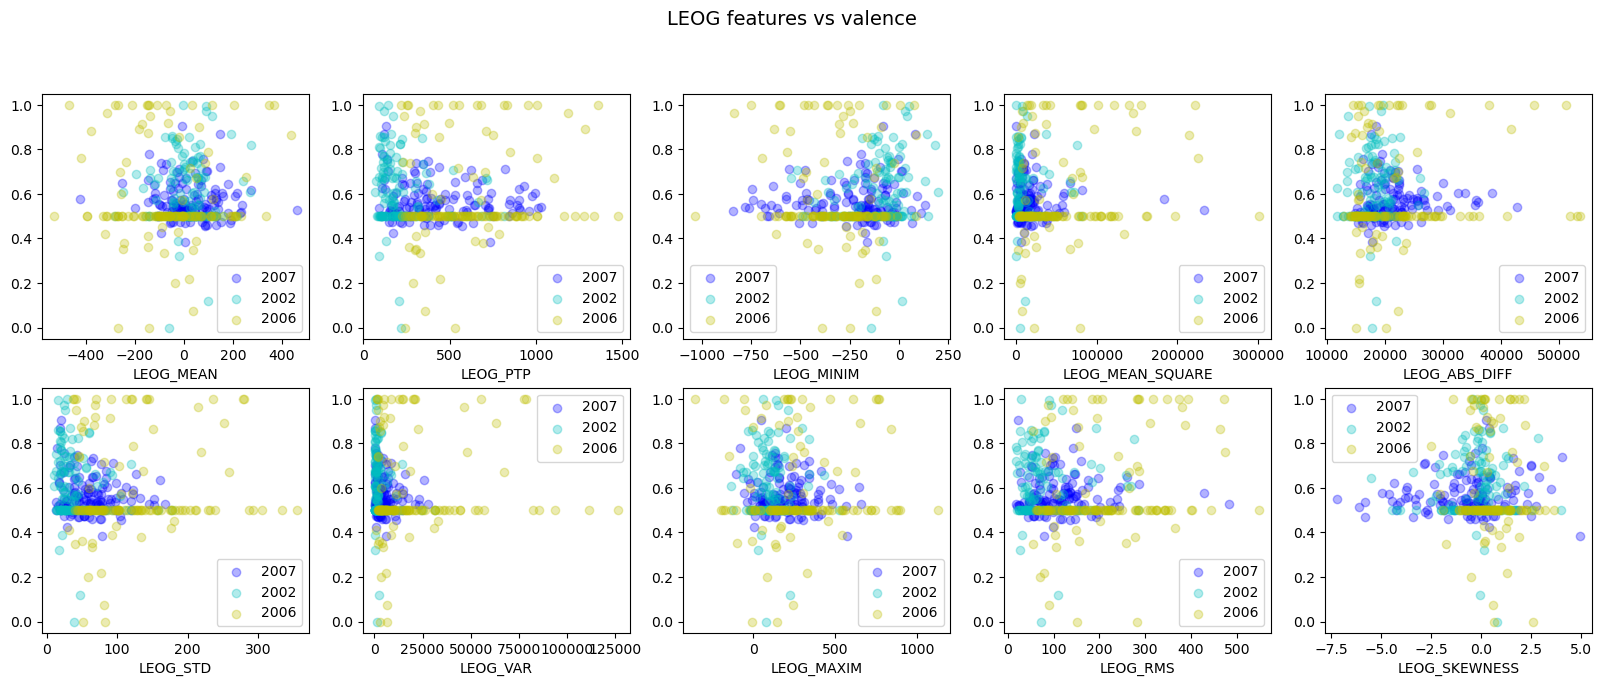

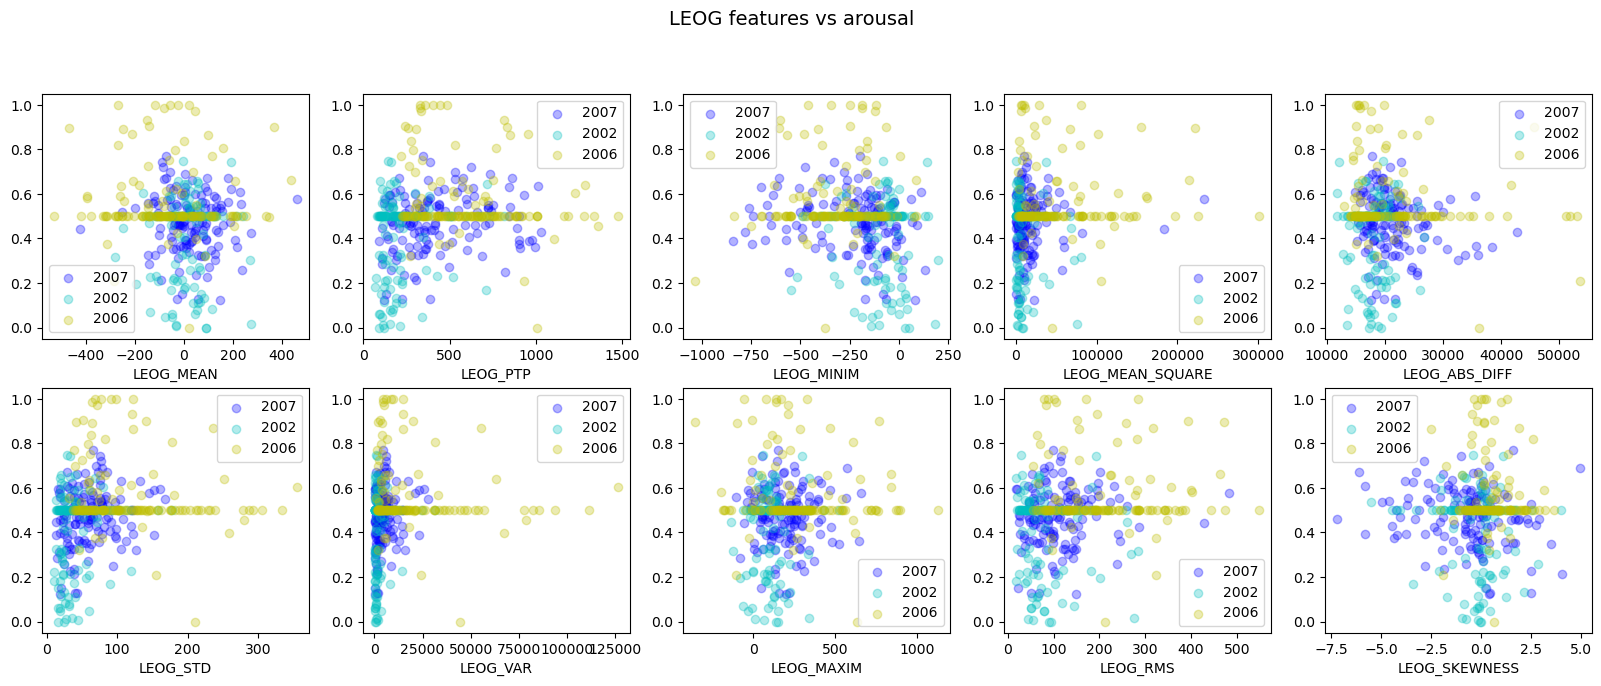

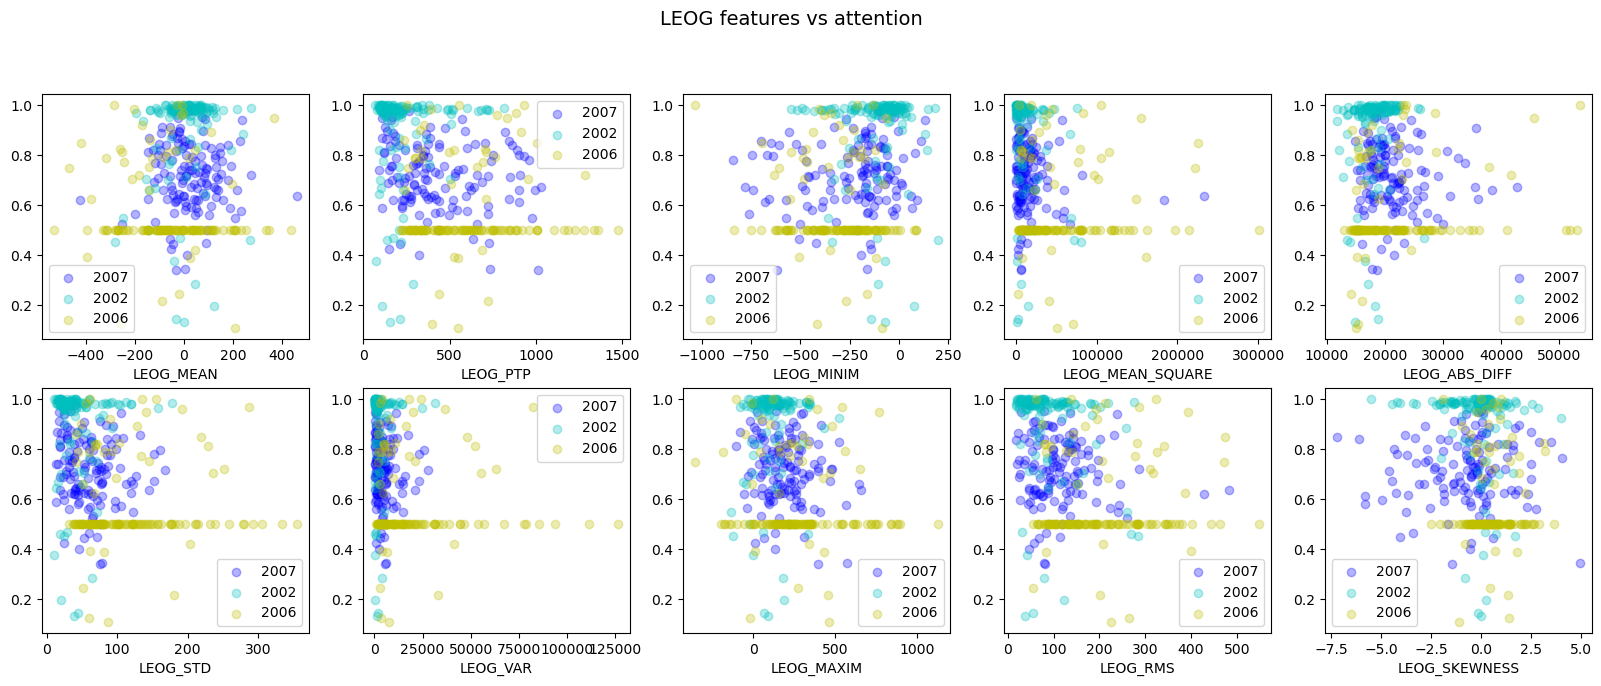

In [58]:
""" 
    plot the scattor for physiological signals
"""
# from plotting import (
#     plot_pd_scatter_by_marker,
# )
# plot_pd_scatter_by_marker("LEOG", result, ['../2007', '../2002', '../2006']) 

In [ ]:
import seaborn as sns

"""
    plot the correlation heatmap
"""
corr = result.corr()
sorted_corr = corr.sort_index().sort_index(axis=1)
truncated_corr = sorted_corr.truncate(
    before="D7_ALPHA", after="VEOG_VAR", axis="rows"
).truncate(before="D7_ALPHA", after="VEOG_VAR", axis="columns")

plt.figure(figsize=(14, 12))
sns.heatmap(truncated_corr, vmin=-1, vmax=1, annot=False, cmap="RdBu_r")

In [ ]:
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
import shap

colors = ["c", "y", "m", "r"]


accuracy = []
gkf = GroupKFold()
label_array = np.array(label_list)

# normalize
scaler = StandardScaler()
normalized_all_feature_array = pd.DataFrame(
    scaler.fit_transform(all_feature_array), columns=all_feature_array.columns
)
#     normalized_all_feature_array = scaler.fit_transform(
#         all_feature_array.reshape(-1, all_feature_array.shape[-1])
#     ).reshape(all_feature_array.shape)

for train_index, val_index in gkf.split(
    normalized_all_feature_array, label_array, groups=group_array
):
    train_features, train_labels = (
        normalized_all_feature_array.iloc[train_index],
        label_array[train_index],
    )
    val_features, val_labels = (
        normalized_all_feature_array.iloc[val_index],
        label_array[val_index],
    )

    # create model instance
    model = XGBClassifier(n_estimators=2)
    # fit model
    model.fit(train_features, train_labels)
    # Print accuracy.
    acc = model.score(val_features, val_labels)
    print("Accuracy: %.2f%%" % (acc * 100.0))
    accuracy.append(acc)

    # Summary plot
    shap_values = shap.TreeExplainer(model).shap_values(val_features)
    color_func = lambda i: colors[i % len(shap_values)]
    shap.summary_plot(
        shap_values,
        all_feature_array.columns,
        class_names=["nvla", "nvha", "hvla", "hvha"],
        color=color_func,
    )


In [ ]:
print(accuracy)
print(np.mean(accuracy))

In [5]:
features = STAT_FEATURES
marker = EOG.__name__

channel_names = dir_to_data["../2002"]["audio_hvla"].get_chanlocs(marker)
channel_num= 0
""" 
    extract features from physiological signals
"""
# features_to_trials = extract_features_by_channel(marker, dir_to_data, features, channel_num, channel_names[channel_num])
# dir_name_to_labels = {}
# for dir_name, all_data in dir_to_data.items():
#     dir_name_to_labels[dir_name] = get_all_behaviors_labels(all_data)

['VEOG', 'LEOG']
dict_keys(['VEOG_MEAN', 'VEOG_STD', 'VEOG_PTP', 'VEOG_VAR', 'VEOG_MINIM', 'VEOG_MAXIM', 'VEOG_MEAN_SQUARE', 'VEOG_RMS', 'VEOG_ABS_DIFF', 'VEOG_SKEWNESS', 'VEOG_KURTOSIS'])


In [39]:
""" 
    extract correlation from physiological signals
"""
num_channels = 4
num_blocks = 0
dir_name_to_ctf = {}
for dir_name, all_data in dir_to_data.items():
    dir_name_to_ctf[dir_name] = get_all_behaviors_feature_to_pc_by_markers(
        all_data, marker, features, num_channels, num_blocks
    )

avg_condition_to_features = get_all_trials_average_rp_values(
    dir_name_to_ctf, features, "pearson"
)
spearman_corr = get_all_trials_average_rp_values(dir_name_to_ctf, features, "spearman")
for b, feature_to_pc in avg_condition_to_features.items():
    for f, pc in feature_to_pc.items():
        avg_condition_to_features[b][f] = np.hstack((pc, spearman_corr[b][f]))


['audio_hvha', 'audio_hvla', 'audio_nvha', 'audio_nvla', 'breath_hvha', 'breath_hvla', 'breath_nvha', 'breath_nvla', 'meditation', 'mind wandering']
Complete computing valence features correlation
Complete computing arousal features correlation
Complete computing attention features correlation
['audio_hvha', 'audio_hvla', 'audio_nvha', 'audio_nvla', 'breath_hvha', 'breath_hvla', 'breath_nvha', 'breath_nvla', 'meditation', 'mind wandering']
Complete computing valence features correlation
Complete computing arousal features correlation
Complete computing attention features correlation
['audio_hvha', 'audio_hvla', 'audio_nvha', 'audio_nvla', 'breath_hvha', 'breath_hvla', 'breath_nvha', 'breath_nvla', 'meditation', 'mind wandering']
Complete computing valence features correlation
Complete computing arousal features correlation
Complete computing attention features correlation
['audio_hvha', 'audio_hvla', 'audio_nvha', 'audio_nvla', 'breath_hvha', 'breath_hvla', 'breath_nvha', 'breath_nvla'

In [ ]:
# from plotting import (
#     plot_series,
#     plot_eeg_topomap_one_block,
#     plot_eeg_topomap_all_blocks,
#     plot_k_chaneels_by_r_value,
#     plot_eeg_pearson_correlation_table,
#     get_eeg_pearson_correlation_series_all_blocks,
#     plot_time_series_by_epoch,
# )

""" 
    plot the time series given the marker and block
"""
# plot_time_series_by_epoch(all_data['audio_hvla'], 'EMG', 'audio_hvla', 0)


""" plot the single channel correlation table
"""
# channel = 3
# for condition, feature_to_pc in avg_condition_to_features.items():
#     label = f"{channel_names[channel]} {condition}"
#     plot_correlation_table_by_channel(
#         label, feature_to_pc, ["pearson r", "pearson p", "spearman r", "spearman p"], features, channel, True
#     )

""" plot the top channel correlation table given r values
"""
# for condition, feature_to_pc in avg_condition_to_features.items():
#     plot_k_chaneels_by_r_value(feature_to_pc, channel_names, features, condition, True, 2)
#     plot_k_chaneels_by_r_value(feature_to_pc, channel_names, features, condition, False, 2)


""" plot the top channel correlation table with different blocks
"""
# all_block_names = list(all_data.keys())
# all_block_names.sort()
# for condition, feature_to_pc in avg_condition_to_features.items():
#     plot_eeg_pearson_correlation_table(condition, feature_to_pc, all_block_names, 1)

""" plot the series for the top k channels
"""
# define number of rows and columns for subplots
# nrow = 3
# ncol = 2
# for condition, feature_to_pc in avg_condition_to_features.items():
#     print(f"{condition}")
#     ser_list = get_eeg_pearson_correlation_series_all_blocks(feature_to_pc, channel_names, k=20)
#     plot_series(nrow, ncol, ser_list)

""" plot the topography for eeg
"""
# for condition, feature_to_pc in avg_condition_to_features.items():
#     plot_eeg_topomap_all_blocks(condition, feature_to_pc)
#     for f in list(EEG_BANDS.keys()):
#         plot_eeg_topomap_one_block(condition, f, feature_to_pc, all_block_names)


In [ ]:
""" 
    concatenate raw signal (x)
"""
data_list = []
for m in [EEG.__name__, EGG.__name__]:  # EOG.__name__, , EMG.__name__, EGG.__name__
    all_participants_data, condition_to_labels = concatenate_all_data(dir_to_data, m)
    all_epoch_data = np.swapaxes(
        all_participants_data, 0, -1
    )  # (num_channels, num_data_points, num_epochs) => (num_epochs, num_data_points, num_channels)

    data_list.append(all_epoch_data)

data_array = np.concatenate(data_list, axis=2)

In [ ]:
from tensorflow.keras import utils as np_utils
from models import cnn_model, train_with_cnn

""" 
    prepare labels (y)
"""
# to one-hot encoding vector
label_array = np_utils.to_categorical(
    label_list, num_classes=4
)  # nvla, nvha, hvla, hvha
# label_array = np.array(label_list['arousal'])

print_label_count(label_list)
print(data_array.shape, label_array.shape, group_array.shape)


num_channel = data_array.shape[2]

model = cnn_model(12288, num_channel)
model.summary()

In [ ]:
""" 
    with CNN
"""
accuracy = train_with_cnn(12288, num_channel, data_array, label_array, group_array)
print(accuracy)
print(np.mean(accuracy))

In [ ]:
""" 
    with logistic regression
"""
# from models import train_with_logistic

# label_name = "attention"
# best_model = train_with_logistic(all_features, label_name, condition_to_labels, group_array)
# name_to_transformed = get_tranformed_labels(condition_to_labels)

# # assume bigger coefficents has more contribution to the model
# # but have to be sure that the features has THE SAME SCALE otherwise this assumption is not correct.
# importance = best_model["classifier"].coef_[0]

# feat_importances = pd.Series(importance, index=get_feature_names(importance))
# feat_importances.nlargest(10).plot(
#     kind="barh", title=f"{label_name} Feature Importance"
# )
